# So sánh dự báo LTSF với FPT_hidden-test

Notebook này tải toàn bộ file dự báo trong thư mục `submissions`, đối chiếu với dữ liệu thực tế `FPT_hidden-test.csv`, tính toán các chỉ số RMSE/MAE/MSE/R² và trực quan hóa top mô hình.

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')

In [56]:
hidden_df = pd.read_csv('FPT_hidden-test.csv')
hidden_df['time'] = pd.to_datetime(hidden_df['time'])
hidden_df = hidden_df.sort_values('time').reset_index(drop=True)
hidden_close = hidden_df['close'].astype(float).values
print(f"FPT_hidden-test length: {len(hidden_df)} rows from {hidden_df['time'].min().date()} to {hidden_df['time'].max().date()}")
display(hidden_df.head())

FPT_hidden-test length: 69 rows from 2025-03-10 to 2025-06-18


,time,open,high,low,close,volume,symbol
0,2025-03-10,122.00,122.00,120.02,120.11,5343134,FPT
1,2025-03-11,118.98,119.42,118.12,118.55,5801595,FPT
2,2025-03-12,118.73,119.59,117.17,117.17,6229823,FPT
3,2025-03-13,117.35,118.98,117.35,117.69,3630282,FPT
4,2025-03-14,116.92,117.52,112.78,113.29,16174178,FPT


In [57]:
submissions_dir = '../submissions'
forecast_files = sorted([f for f in os.listdir(submissions_dir) if f.startswith('Sub_') and f.endswith('.csv')])
if not forecast_files:
    raise FileNotFoundError('Không tìm thấy file dự báo trong thư mục submissions.')

records = []
max_len = len(hidden_close)
for filename in forecast_files:
    file_path = os.path.join(submissions_dir, filename)
    forecast_df = pd.read_csv(file_path)
    preds = forecast_df['close'].astype(float).values
    aligned_len = min(len(preds), max_len)
    preds_clip = preds[:aligned_len]
    actual_clip = hidden_close[:aligned_len]
    mse = mean_squared_error(actual_clip, preds_clip)
    mae = mean_absolute_error(actual_clip, preds_clip)
    rmse = np.sqrt(mse)
    try:
        r2 = r2_score(actual_clip, preds_clip)
    except ValueError:
        r2 = np.nan
    slug = filename.replace('Sub_', '').replace('.csv', '')
    model_name = slug
    records.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'ForecastFile' : file_path
    })

comparison_df = pd.DataFrame(records).sort_values('RMSE').reset_index(drop=True)
print('Bảng so sánh theo RMSE tăng dần:')
display(comparison_df)

Bảng so sánh theo RMSE tăng dần:


,Model,RMSE,MAE,MSE,R2,ForecastFile
0,Univariate_Linear_RevIN_Huber_NoHMM_Seq480_MSE...,5.308191,4.342444,28.176892,0.326960,../submissions/Sub_Univariate_Linear_RevIN_Hub...
1,Univariate_Linear_RevIN_MSE_NoHMM_Seq480_MSE4888,5.308282,4.342501,28.177857,0.326937,../submissions/Sub_Univariate_Linear_RevIN_MSE...
2,Univariate_DLinear_RevIN_Huber_NoHMM_Seq480_MS...,5.438176,4.190128,29.573762,0.293594,../submissions/Sub_Univariate_DLinear_RevIN_Hu...
3,Univariate_DLinear_RevIN_MSE_NoHMM_Seq480_MSE5073,5.438371,4.190104,29.575878,0.293543,../submissions/Sub_Univariate_DLinear_RevIN_MS...
4,Univariate_Linear_RevIN_MAE_NoHMM_Seq480_MSE4893,6.699544,5.338409,44.883884,-0.072108,../submissions/Sub_Univariate_Linear_RevIN_MAE...
...,...,...,...,...,...,...
655,Univariate_Linear_NoRevIN_Huber_HMM3W30_Seq60_...,39.942203,38.557719,1595.379556,-37.107637,../submissions/Sub_Univariate_Linear_NoRevIN_H...
656,Univariate_Linear_NoRevIN_MSE_HMM3W30_Seq60_MS...,40.325783,38.730934,1626.168793,-37.843076,../submissions/Sub_Univariate_Linear_NoRevIN_M...
657,Multivariate_Linear_NoRevIN_Huber_HMM3W60_Seq6...,40.746578,36.649111,1660.283655,-38.657952,../submissions/Sub_Multivariate_Linear_NoRevIN...
658,Univariate_Linear_NoRevIN_MSE_NoHMM_Seq60_MSE117,41.148827,39.480240,1693.225959,-39.444820,../submissions/Sub_Univariate_Linear_NoRevIN_M...


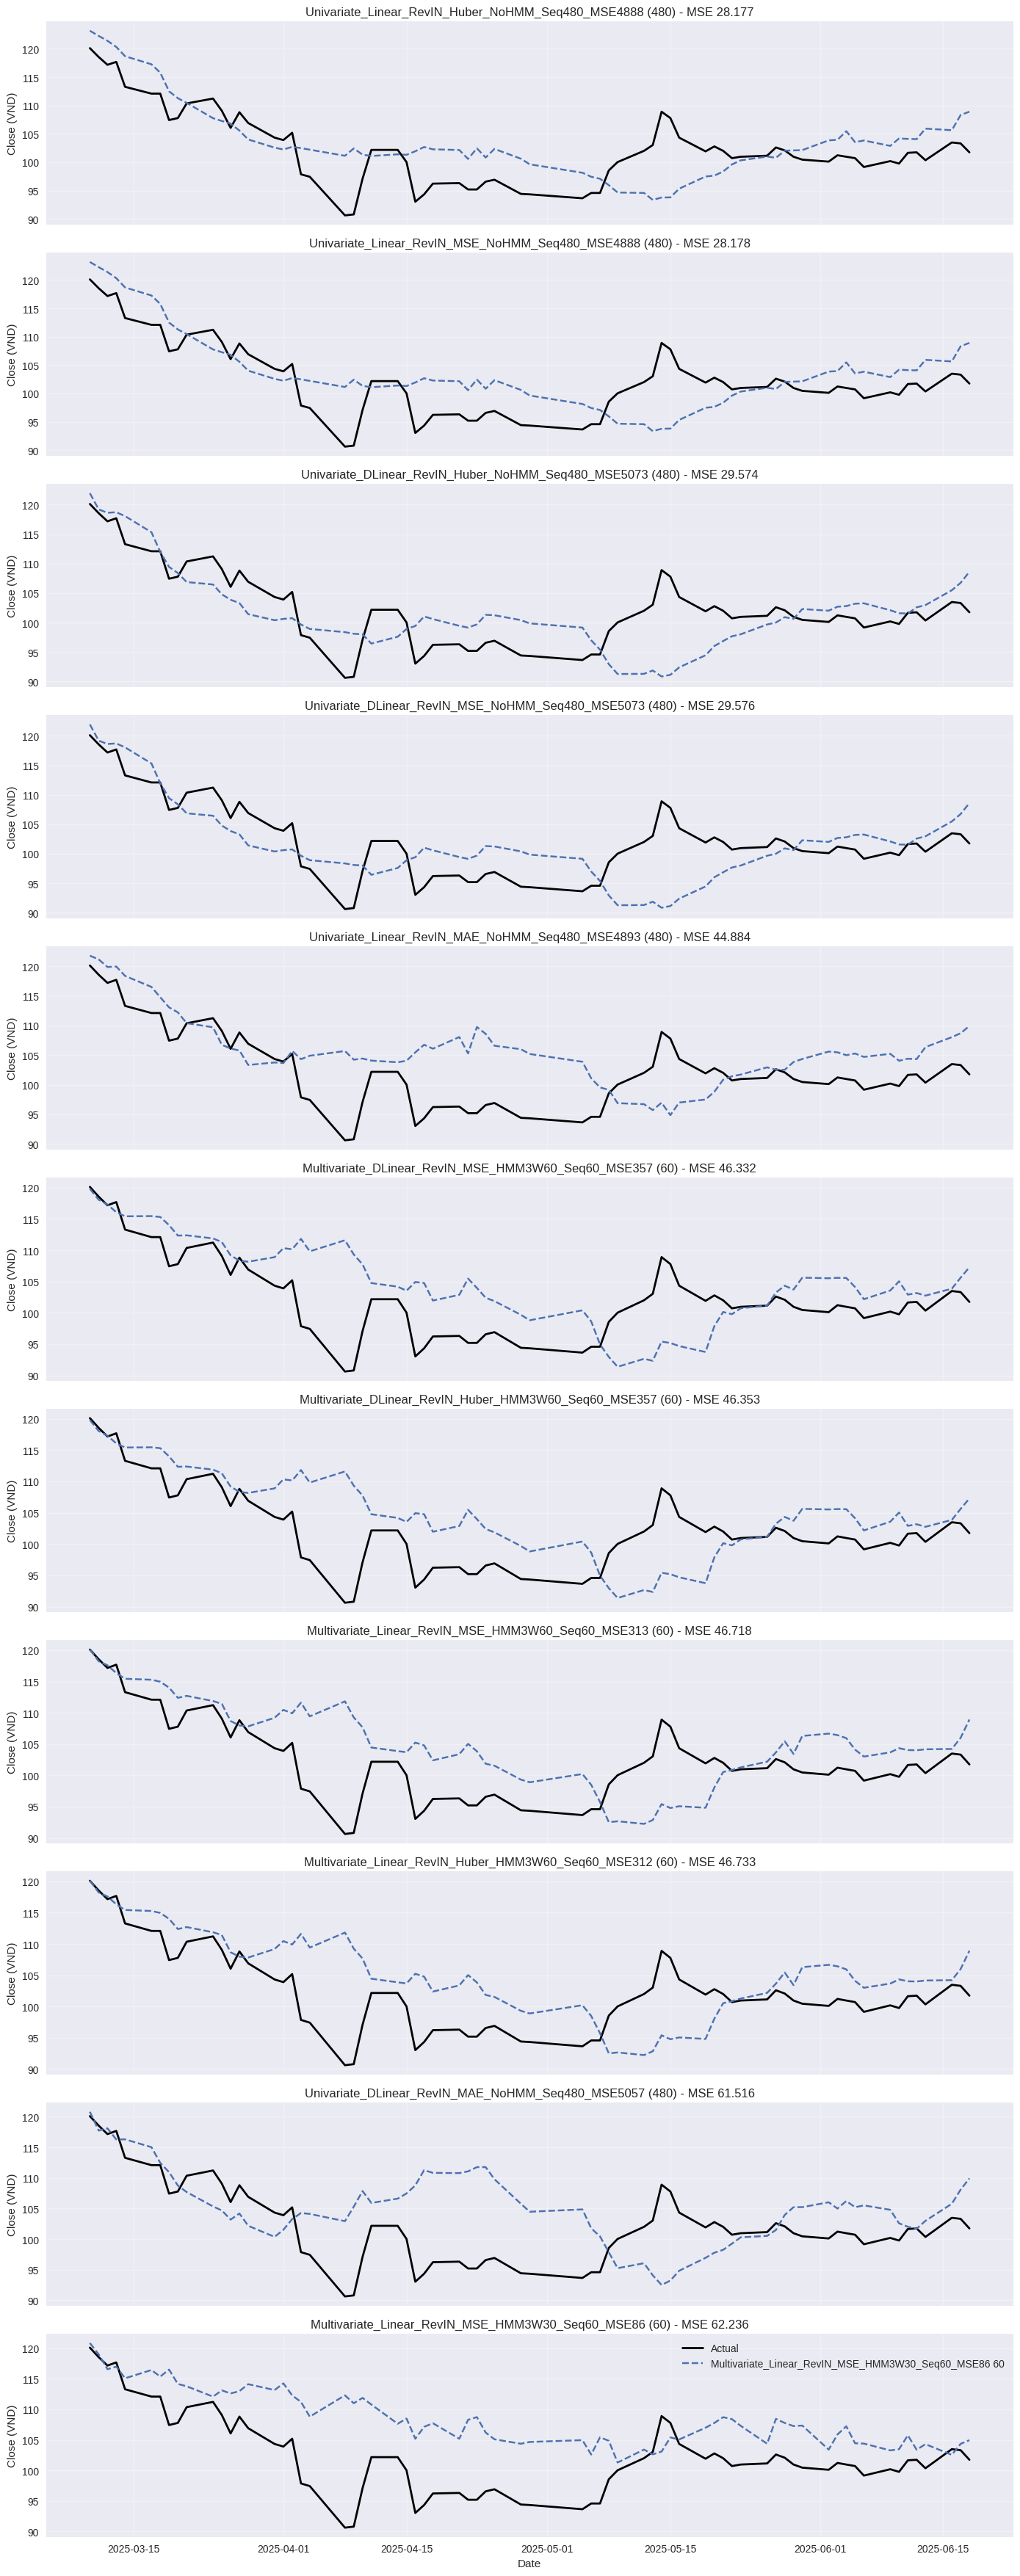

In [58]:
# top_k = min(4, len(comparison_df))
top_k = 11
if top_k == 0:
    print('Không có bản ghi để vẽ.')
else:
    fig, axes = plt.subplots(top_k, 1, figsize=(14, 3.2 * top_k), sharex=True)
    if top_k == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, comparison_df.head(top_k).iterrows()):
        forecast_df = pd.read_csv(row['ForecastFile'])
        preds = forecast_df['close'].astype(float).values
        aligned_len = min(len(preds), len(hidden_close))
        ax.plot(hidden_df['time'][:aligned_len], hidden_close[:aligned_len], label='Actual', color='black', linewidth=2)
        # Fix for missing Horizon key
        horizon = row.get('Horizon')
        if pd.isna(horizon) or horizon is None:
            import re
            match = re.search(r'Seq(\d+)', str(row['Model']))
            horizon = match.group(1) if match else 'Unknown'
        ax.plot(hidden_df['time'][:aligned_len], preds[:aligned_len], label=f"{row['Model']} {horizon}", linestyle='--')
        ax.set_title(f"{row['Model']} ({horizon}) - MSE {row['MSE']:.3f}")
        ax.set_ylabel('Close (VND)')
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel('Date')
    axes[-1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [59]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Cấu hình đường dẫn (Lưu ý: Grid Search save vào 'submissions' ở thư mục hiện tại)
# Nếu bạn chạy notebook này cùng cấp với notebook Grid Search thì dùng 'submissions'
# Nếu bạn chạy trong thư mục con thì dùng '../submissions'
submissions_dir = 'submissions' 

if not os.path.exists(submissions_dir):
    # Fallback thử thư mục cha nếu không tìm thấy
    if os.path.exists('../submissions'):
        submissions_dir = '../submissions'
    else:
        os.makedirs(submissions_dir, exist_ok=True)
        print(f"⚠️ Đã tạo thư mục {submissions_dir} (đang trống). Hãy copy file dự báo vào đây.")

# 2. Lọc file (Lấy cả file cũ 'submission_' và file mới 'Sub_')
forecast_files = sorted([f for f in os.listdir(submissions_dir) 
                         if f.endswith('.csv') and (f.startswith('submission_') or f.startswith('Sub_'))])

if not forecast_files:
    print(f"⚠️ Không tìm thấy file .csv nào trong {submissions_dir}")
else:
    print(f"Đã tìm thấy {len(forecast_files)} file dự báo.")

records = []
# Đảm bảo hidden_close đã được load từ cell trước đó
max_len = len(hidden_close) 

for filename in forecast_files:
    file_path = os.path.join(submissions_dir, filename)
    try:
        forecast_df = pd.read_csv(file_path)
        
        # Kiểm tra cột close
        if 'close' not in forecast_df.columns:
            continue
            
        preds = forecast_df['close'].astype(float).values
        
        # Cắt ngắn hoặc giữ nguyên độ dài để so sánh
        aligned_len = min(len(preds), max_len)
        if aligned_len == 0: continue
            
        preds_clip = preds[:aligned_len]
        actual_clip = hidden_close[:aligned_len]
        
        # Tính toán metrics
        mse = mean_squared_error(actual_clip, preds_clip)
        mae = mean_absolute_error(actual_clip, preds_clip)
        rmse = np.sqrt(mse)
        try:
            r2 = r2_score(actual_clip, preds_clip)
        except:
            r2 = np.nan
            
        # --- LOGIC PARSE TÊN FILE MỚI ---
        # Format mới: Sub_{Model}_{HMM}_{Win}_{Seq}_{MSE}.csv
        # Format cũ: submission_{model}_{horizon}_100d.csv
        slug = filename.replace('.csv', '')
        
        if filename.startswith('Sub_'):
            parts = slug.split('_')
            # Logic: 4 phần tử cuối cùng luôn là HMM, Win, Seq, MSE
            # Các phần tử từ index 1 đến -4 là tên Model (có thể chứa dấu _)
            if len(parts) >= 6:
                mse_tag = parts[-1]   # MSExxx
                mse_train = int(mse_tag.replace('MSE', ''))
                seq_tag = parts[-2]   # Seqxxx
                win_tag = parts[-3]   # Winxxx
                hmm_tag = parts[-4]   # HMMx hoặc NoHMM
                
                model_name = "_".join(parts[1:-4])
                info_str = f"{hmm_tag} | {seq_tag}"
            else:
                model_name = slug
                info_str = "Custom"
        else:
            # Xử lý file cũ
            clean_name = slug.replace('submission_', '').replace('_100d', '')
            model_name = clean_name
            info_str = "Legacy"

        records.append({
            'Model': model_name,
            'Config': info_str,
            'MSE': mse,
            'MSE train': mse_train,
            'R2': r2,
            'Filename': filename
        })
        
    except Exception as e:
        print(f"Lỗi khi đọc file {filename}: {e}")

# Tạo bảng so sánh
if records:
    comparison_df = pd.DataFrame(records).sort_values('MSE').reset_index(drop=True)
    
    # Highlight top model
    print(f"\n🏆 TOP 1 MODEL: {comparison_df.iloc[0]['Model']} ({comparison_df.iloc[0]['Config']})")
    print(f"   MSE: {comparison_df.iloc[0]['MSE']:.2f}")
    
    print('\nBảng xếp hạng chi tiết (Theo MSE thấp nhất):')
    # Format lại hiển thị cho đẹp
    display(comparison_df.style.background_gradient(subset=['MSE', 'MSE train'], cmap='RdYlGn_r'))
else:
    print("Chưa có dữ liệu để so sánh.")

Đã tìm thấy 660 file dự báo.

🏆 TOP 1 MODEL: Univariate_Linear_RevIN (Huber | Seq480)
   MSE: 28.18

Bảng xếp hạng chi tiết (Theo MSE thấp nhất):


,Model,Config,MSE,MSE train,R2,Filename
0,Univariate_Linear_RevIN,Huber | Seq480,28.176892,4888,0.326960,Sub_Univariate_Linear_RevIN_Huber_NoHMM_Seq480_MSE4888.csv
1,Univariate_Linear_RevIN,MSE | Seq480,28.177857,4888,0.326937,Sub_Univariate_Linear_RevIN_MSE_NoHMM_Seq480_MSE4888.csv
2,Univariate_DLinear_RevIN,Huber | Seq480,29.573762,5073,0.293594,Sub_Univariate_DLinear_RevIN_Huber_NoHMM_Seq480_MSE5073.csv
3,Univariate_DLinear_RevIN,MSE | Seq480,29.575878,5073,0.293543,Sub_Univariate_DLinear_RevIN_MSE_NoHMM_Seq480_MSE5073.csv
4,Univariate_Linear_RevIN,MAE | Seq480,44.883884,4893,-0.072108,Sub_Univariate_Linear_RevIN_MAE_NoHMM_Seq480_MSE4893.csv
5,Multivariate_DLinear_RevIN,MSE | Seq60,46.332051,357,-0.106699,Sub_Multivariate_DLinear_RevIN_MSE_HMM3W60_Seq60_MSE357.csv
6,Multivariate_DLinear_RevIN,Huber | Seq60,46.353421,357,-0.107209,Sub_Multivariate_DLinear_RevIN_Huber_HMM3W60_Seq60_MSE357.csv
7,Multivariate_Linear_RevIN,MSE | Seq60,46.718402,313,-0.115927,Sub_Multivariate_Linear_RevIN_MSE_HMM3W60_Seq60_MSE313.csv
8,Multivariate_Linear_RevIN,Huber | Seq60,46.732621,312,-0.116267,Sub_Multivariate_Linear_RevIN_Huber_HMM3W60_Seq60_MSE312.csv
9,Univariate_DLinear_RevIN,MAE | Seq480,61.515656,5057,-0.469378,Sub_Univariate_DLinear_RevIN_MAE_NoHMM_Seq480_MSE5057.csv
